### Make toy data for package testing

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os,sys
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
adata = sc.read_h5ad('/home/jovyan/mount/gdrive/query2reference/processed_data/pbmc_10k_protein_v3.h5ad')

In [4]:
seed = 1042
X_dims = 'X_pca'

## Random assign to 10 donors and 2 conditions
np.random.seed(seed)
adata.obs["condition"] = np.random.choice(
        ["Condition", "Ctrl"], size=adata.n_obs, p=[0.5, 0.5])
adata.obs["replicate"] = np.random.choice([f"R{x + 1}"  for x in np.arange(5)], size=adata.n_obs)
adata.obs["sample"] = adata.obs["replicate"] + adata.obs["condition"]

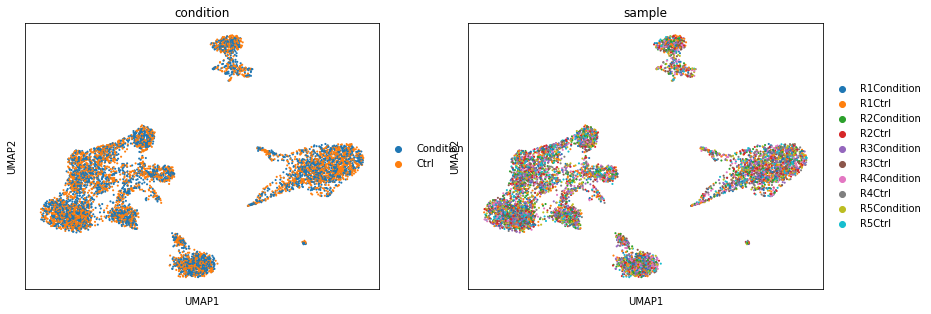

In [5]:
sc.pl.umap(adata, color=['condition', 'sample'])

In [6]:
### run celltypist to have uncertainty metric
import celltypist
model = celltypist.models.Model.load(model = 'Immune_All_Low.pkl')

sc.pp.normalize_total(adata, target_sum=10000)
sc.pp.log1p(adata)

predictions = celltypist.annotate(adata, model = 'Immune_All_Low.pkl', majority_voting = False)

🔬 Input data has 6855 cells and 16727 genes
🔗 Matching reference genes in the model
🧬 1842 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!


In [7]:
adata = predictions.to_adata()

In [10]:
adata.write_h5ad('/nfs/team205/ed6/bin/query2reference_uncertainty/data/pbmc_testing.h5ad')

In [4]:
adata = sc.read_h5ad('/nfs/team205/ed6/bin/query2reference_uncertainty/data/pbmc_testing.h5ad')

### Testing core funcs

In [354]:
sys.path.append('/nfs/team205/ed6/bin/query2reference_uncertainty/') 
from q2r_uncertainty.core import *
from q2r_uncertainty.plotting import plot_nhood_confidence_boxplot

In [286]:
confidence_col = 'conf_score'
clusters_key = 'leiden'

make_cell_nhoods(adata, method='clusters', clusters_key='leiden')
nhood_confidence(adata, confidence_col='conf_score', sample_col='sample')
make_design(adata, categorical_covariates=['condition'])

/nfs/team205/ed6/bin/query2reference_uncertainty/q2r_uncertainty/core.py:101: RuntimeWarning: invalid value encountered in true_divide
  nh_score = nh_score/np.array(nhood_mat[ixs, :].T.sum(1))
/home/jovyan/my-conda-envs/test_milopy2/lib/python3.10/site-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['R1Condition', 'R1Ctrl', 'R2Condition', 'R2Ctrl', 'R3Condition']

    Inferred to be: categorical

  value_idx = self._prep_dim_index(value.index, attr)
/home/jovyan/my-conda-envs/test_milopy2/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [289]:
test_confidence(adata, test_covariate='condition', method='t-test', ref_level='Condition')

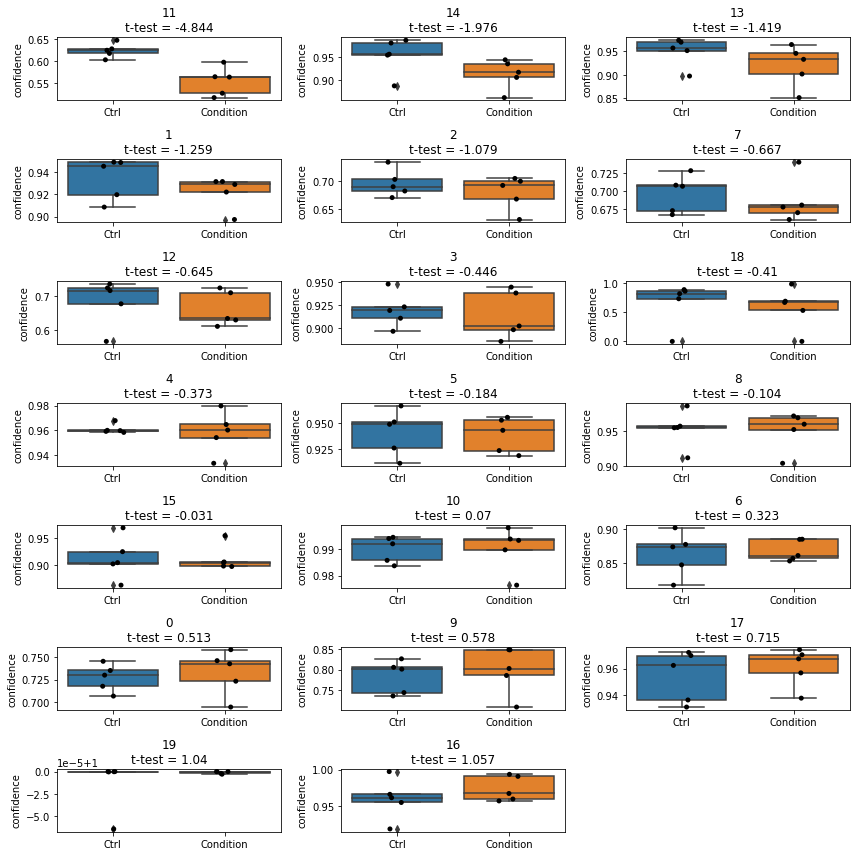

In [293]:
plt.rcParams['figure.figsize'] = [12,12]
plt.subplot(1,2,1);
sorted_obs = adata.uns['nhood_adata'].obs['confidence_test_statistic'].sort_values().index 
plot_nhood_confidence_boxplot(adata, sorted_obs, 
n_cols=3,
# ylim=[0,1]
);


In [291]:
nhood_adata = adata.uns['nhood_adata'].copy()

In [292]:
nhood_adata.obs.sort_values("confidence_test_pvals")

,confidence_test_statistic,confidence_test_pvals,confidence_test_adj_pvals,Nhood_size
11,-4.843815,0.003037,0.060742,228
14,-1.975949,0.084986,0.849856,154
13,-1.418616,0.198278,0.947217,194
1,-1.259484,0.245648,0.947217,717
2,-1.079097,0.313432,0.947217,641
16,1.057048,0.327378,0.947217,113
19,1.039656,0.356959,0.947217,28
17,0.715216,0.496216,0.947217,85
7,-0.666939,0.524251,0.947217,356
12,-0.645325,0.538241,0.947217,217


In [294]:
get_mean_confidence(nhood_adata, nhood_adata.uns['test_confidence']['test_covariate'], 'Condition') 
get_mean_confidence(nhood_adata, nhood_adata.uns['test_confidence']['test_covariate'], 'Ctrl') 

In [295]:
def abs_log2fc(adata,grouptype,group2,group1):
    # calculate the absolute log2-foldchange as log2(b/a) = (ln(b)-ln(a))/ln(2)
    # data is ln(counts+1), neglect the +1
    obs_df=pd.DataFrame(adata.X.toarray(),columns=adata.var_names)
    obs_df[grouptype]=adata.obs[grouptype].values    
    x=obs_df.groupby([grouptype])
    tot=x[adata.var_names].apply(np.mean)
    lfc= (tot.loc[group2] - tot.loc[group1])/np.log(2)
    return lfc

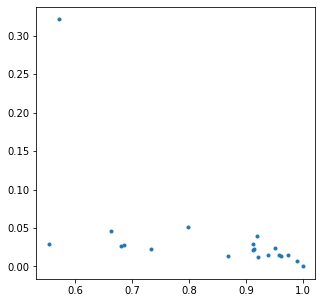

In [359]:
means = get_confidence_stats(nhood_adata, 'mean', test_covariate=test_covariate, cov_level=ref_level)
vars = get_confidence_stats(nhood_adata, 'var', test_covariate=test_covariate, cov_level=ref_level)
plt.plot(means, np.sqrt(vars), '.');

/home/jovyan/my-conda-envs/test_milopy2/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


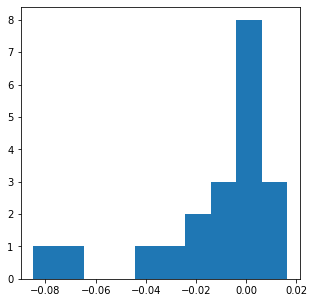

In [353]:
test_covariate = nhood_adata.uns['test_confidence']['test_covariate']
ref_level = nhood_adata.uns['test_confidence']['ref_level']

conf_df = pd.DataFrame(nhood_adata.layers['confidence'].T, columns=nhood_adata.obs_names)
conf_df[test_covariate] = nhood_adata.var[test_covariate].values  
x = conf_df.groupby([test_covariate])
tot = x[nhood_adata.obs_names].apply(np.mean)

gr1 = tot.loc[ref_level].values
gr0 = tot.loc[tot.index != ref_level].values
# lfc = (np.log2(gr1/gr0)).ravel()
lfc = (gr1 - gr0).ravel()
plt.hist(lfc);

In [323]:
obs_df=pd.DataFrame(adata.X,columns=adata.var_names)
obs_df[test_covariate]=adata.obs[test_covariate].values    
x=obs_df.groupby([test_covariate])
tot=x[adata.var_names].apply(np.mean)
# lfc= (tot.loc[group2] - tot.loc[group1])/np.log(2)

/home/jovyan/my-conda-envs/test_milopy2/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [324]:
tot

index,AL627309.1,AL669831.5,LINC00115,FAM41C,NOC2L,KLHL17,PLEKHN1,AL645608.8,HES4,ISG15,...,MT-ND4,MT-ND5,MT-ND6,MT-CYB,AC011043.1,AL592183.1,AC007325.4,AL354822.1,AC004556.1,AC240274.1
condition,,,,,,,,,,,,,,,,,,,,,
Condition,0.001986,0.063256,0.027115,0.042359,0.240357,0.033479,0.006421,0.002181,0.018396,0.383635,...,3.911232,2.353651,0.142667,3.832142,0.003358,0.111755,0.010227,0.003947,0.173043,0.006077
Ctrl,0.002006,0.056388,0.024868,0.036015,0.237025,0.032802,0.008860,0.000841,0.018766,0.389646,...,3.926196,2.359285,0.152804,3.828199,0.005031,0.115565,0.006435,0.003295,0.165272,0.004855


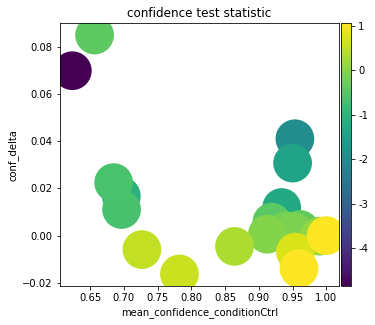

In [296]:
plt.rcParams['figure.figsize'] = [5,5]
sc.pl.scatter(nhood_adata,'mean_confidence_conditionCtrl', 'conf_delta', color='confidence_test_statistic')

In [234]:
import statsmodels.api as sm

bin_model = sm.GLM(y, test_vec, family=sm.families.Binomial())
bin_results = bin_model.fit()
bin_results